.. index:: Equations; Advection-Diffusion-Reaction

# An Advection-Diffusion-Reaction System: Chemical Reaction Problem

In [1]:
try:
    import dune.femdg
except ImportError:
    print("This example needs 'dune.femdg' - skipping")
    import sys
    sys.exit(0)

import numpy
from matplotlib import pyplot
from ufl import *
from dune.ufl import DirichletBC
from dune.grid import structuredGrid
from dune.fem.plotting import plotPointData as plot
from dune.fem.space import lagrange, dgonb
from dune.fem.scheme import galerkin
from dune.femdg import femDGOperator
from dune.femdg.rk import femdgStepper
from dune.femdg import BndValue, BndFlux_v, BndFlux_c

from dune.fem import threading
threading.use = max(4,threading.max) # use at most 4 threads

gridView = structuredGrid([0,0],[2*numpy.pi,2*numpy.pi],[20,20])

Method to compute the velocity based on a scalar elliptic equation

In [2]:
def computeVelocity():
    streamSpace = lagrange(gridView, order=1, dimRange=1)
    Psi  = streamSpace.interpolate(0,name="streamFunction")
    u,v  = TrialFunction(streamSpace), TestFunction(streamSpace)
    x    = SpatialCoordinate(streamSpace)
    form = ( inner(grad(u),grad(v)) - 5*sin(x[0])*sin(x[1]) * v[0] ) * dx
    streamScheme = galerkin([form == 0, DirichletBC(streamSpace,[0]) ])
    streamScheme.solve(target=Psi)
    return as_vector([-Psi[0].dx(1),Psi[0].dx(0)])

Chemical reaction model

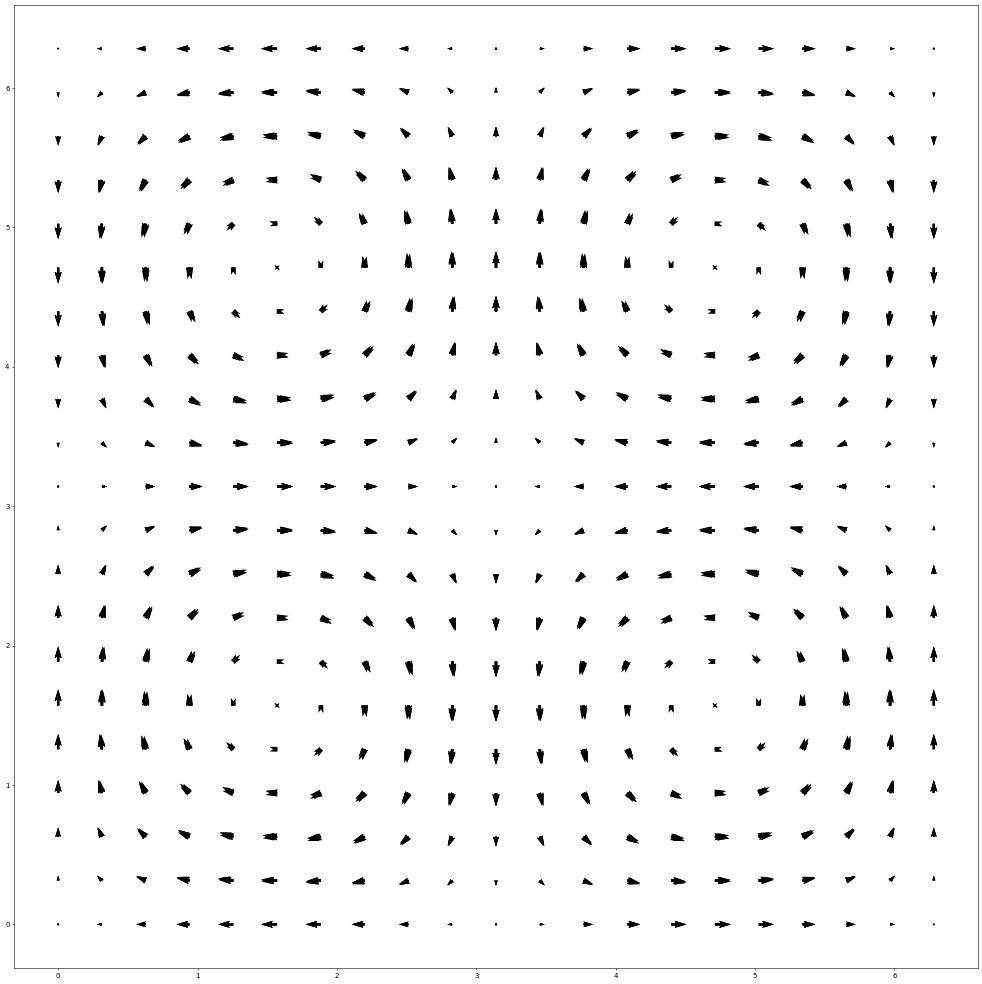

In [3]:
class Model:
    transportVelocity = computeVelocity()
    @classmethod
    def S_e(cls,t,x,U,DU):
        P1 = as_vector([0.2*pi,0.2*pi]) # midpoint of first source
        P2 = as_vector([1.8*pi,1.8*pi]) # midpoint of second source
        f1 = conditional(dot(x-P1,x-P1) < 0.2, 1, 0)
        f2 = conditional(dot(x-P2,x-P2) < 0.2, 1, 0)
        f  = conditional(t<5, as_vector([f1,f2,0]), as_vector([0,0,0]))
        r = 10*as_vector([U[0]*U[1], U[0]*U[1], -2*U[0]*U[1]])
        return f - r
    @classmethod
    def F_c(cls,t,x,U):
        return as_matrix([ [*(Model.velocity(t,x,U)*u)] for u in U ])
    @classmethod
    def maxWaveSpeed(cls,t,x,U,n):
        return abs(dot(Model.velocity(t,x,U),n))
    @classmethod
    def velocity(cls,t,x,U):
        return Model.transportVelocity
    @classmethod
    def F_v(cls,t,x,U,DU):
        return 0.02*DU
    @classmethod
    def physical(cls,t,x,U):
        return conditional(U[0]>=0,1,0)*conditional(U[1]>=0,1,0)*\
               conditional(U[2]>=0,1,0)
    boundary = {range(1,5): BndValue(as_vector([0,0,0]))}

fig = pyplot.figure(figsize=(20,20))
plot(Model.transportVelocity, gridView=gridView, gridLines=None, vectors=[0,1],figure=fig)

Time evolution scheme

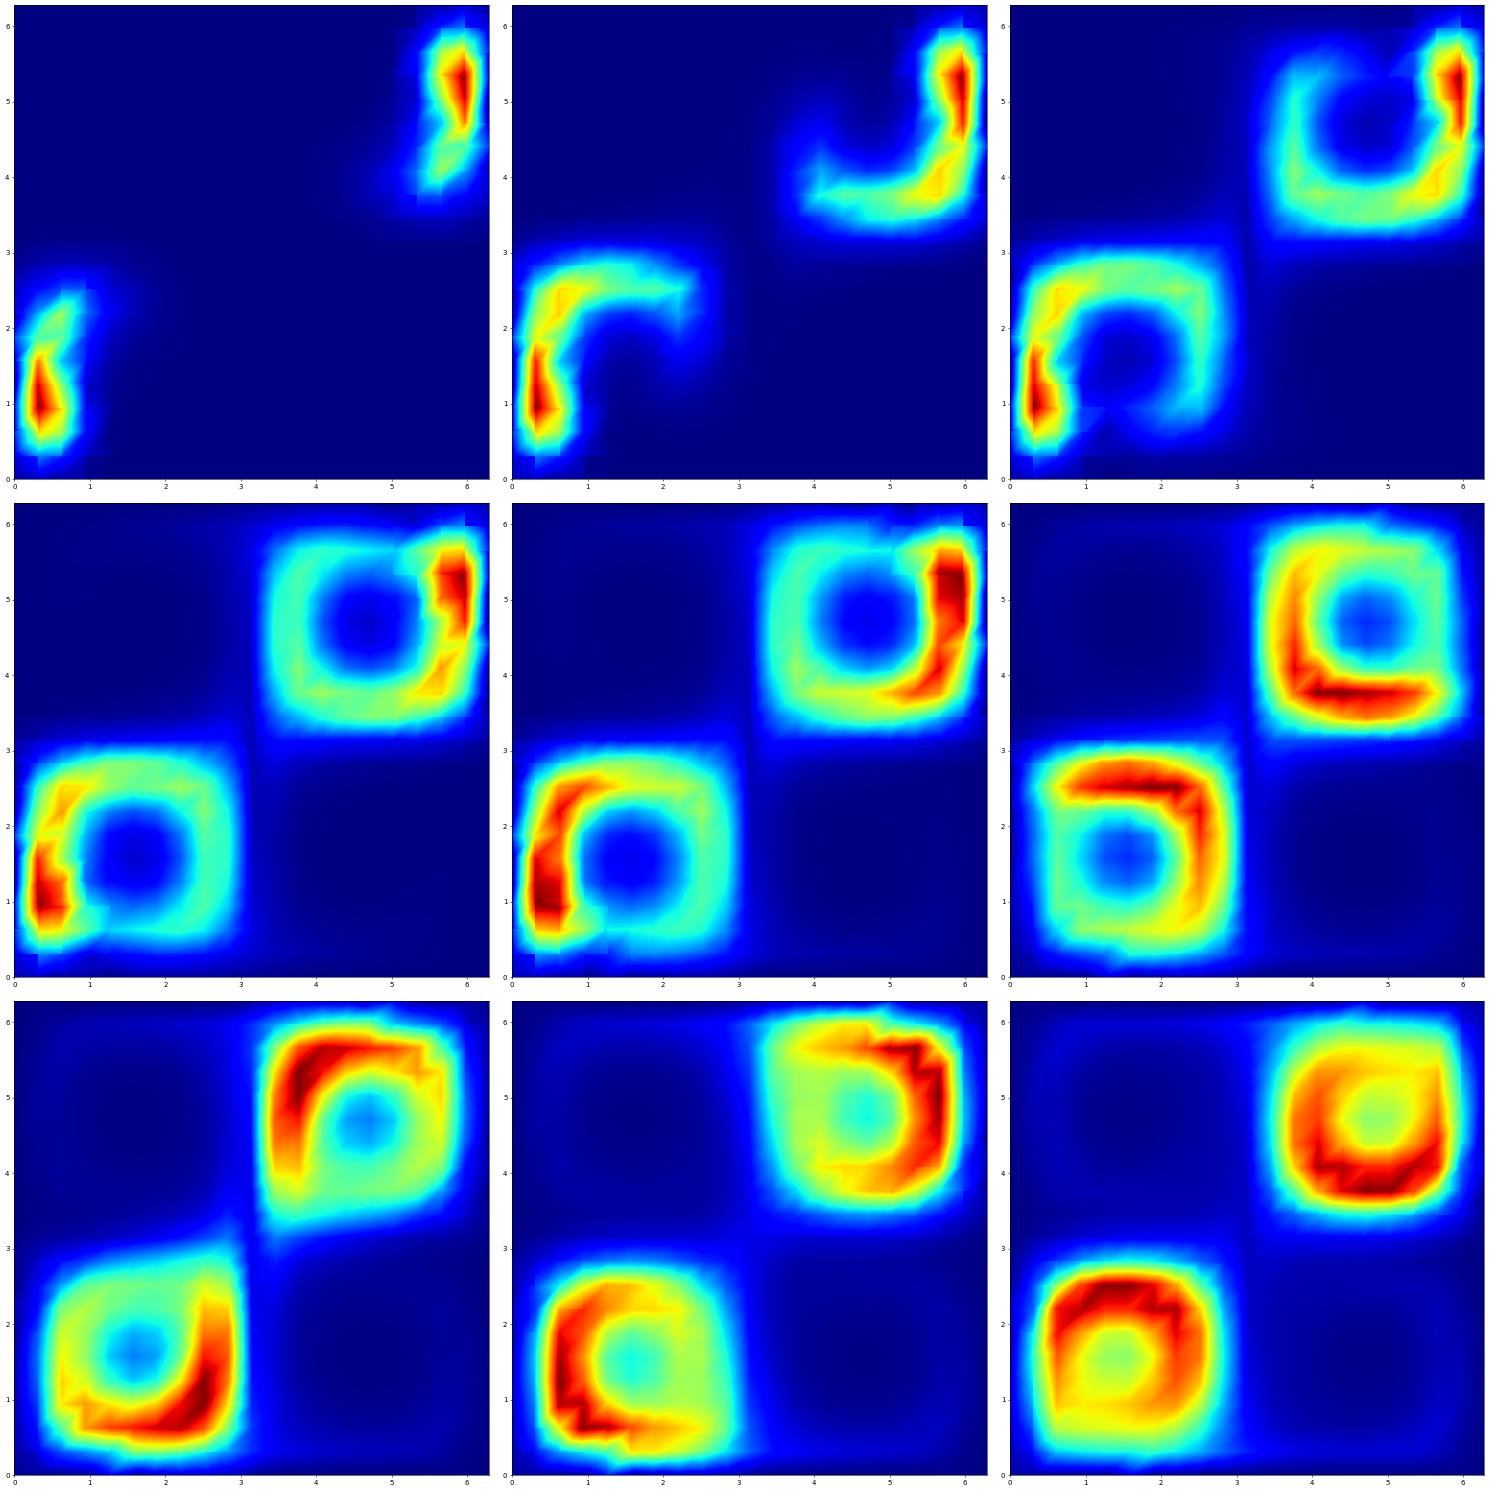

In [4]:
space    = dgonb( gridView, order=3, dimRange=3)
u_h      = space.interpolate([0,0,0], name='u_h')
operator = femDGOperator(Model, space, limiter="scaling")
stepper  = femdgStepper(order=3, operator=operator)
operator.applyLimiter(u_h)

t        = 0
saveTime = 1

fig = pyplot.figure(figsize=(30,30))
c = 0
while t < 9:
    operator.setTime(t)
    t += stepper(u_h)
    if t > saveTime:
        saveTime += 1
        u_h.plot(gridLines=None, figure=(fig, 331+c), colorbar=False)
        c += 1

All three components

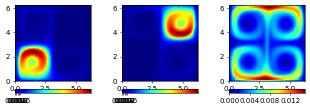

In [5]:
from dune.fem.plotting import plotComponents
from matplotlib import ticker
plotComponents(u_h, gridLines=None, level=1,
               colorbar={"orientation":"horizontal", "ticks":ticker.MaxNLocator(nbins=4)})